# PREDICCIONES REG TREES para el amba

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# Read vCensosAmba
df = read_table_into_dataframe('public.proyecciones')
df=df.sort_values(by=['Departamento', 'ano'])
if df is not None:
    print(df)
dataframe_to_latex(df.head(10), 'proyecciones2025.tex')

    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image



      id CodigoDpto   ano     Departamento  Poblacion  Varones  Mujeres
0    385       6028  2010  Almirante Brown     557025   273352   283673
23   408       6028  2011  Almirante Brown     561349   275570   285779
46   431       6028  2012  Almirante Brown     565509   277794   287715
69   454       6028  2013  Almirante Brown     569911   279980   289931
92   477       6028  2014  Almirante Brown     574263   282143   292120
..   ...        ...   ...              ...        ...      ...      ...
275  660       6861  2021    Vicente López     267257   126023   141234
298  683       6861  2022    Vicente López     266880   125932   140948
321  706       6861  2023    Vicente López     266538   125851   140687
344  729       6861  2024    Vicente López     266203   125780   140423
367  752       6861  2025    Vicente López     265885   125719   140166

[368 rows x 7 columns]


In [4]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 368 entries, 0 to 367
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            368 non-null    int64 
 1   CodigoDpto    368 non-null    object
 2   ano           368 non-null    int64 
 3   Departamento  368 non-null    object
 4   Poblacion     368 non-null    int64 
 5   Varones       368 non-null    int64 
 6   Mujeres       368 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 23.0+ KB


id              0
CodigoDpto      0
ano             0
Departamento    0
Poblacion       0
Varones         0
Mujeres         0
dtype: int64

In [5]:
# READ TASAS .csv
dfTasas = pd.read_csv('C:/Users/Fer/ITBA_TFI/datasets/tasasBA.csv',sep=';', header='infer')

# Display the first few rows of the DataFrame
print(dfTasas.head())

dataframe_to_latex(dfTasas, 'tasas.tex')

   Jurisdicción   Año   TMI   TGF   TBN  TBM     TCV    Mat1ria
0  BUENOS AIRES  1980  28.4  3.00  22.1  8.1  14.000        NaN
1  BUENOS AIRES  1991  24.2  2.60  18.4  7.9  10.500  1752994.0
2  BUENOS AIRES  2001  15.0  2.30  16.9  8.2   8.700  1658221.0
3  BUENOS AIRES  2010  12.0  2.50  18.9  8.4  10.500  1667278.0
4  BUENOS AIRES  2022   7.9  1.89   9.7  8.8   0.899  1767473.0


In [6]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
df=df.sort_values('nam')
df.drop('Superficie', axis=1, inplace=True)
if df is not None:
    print(df)


                nam cod_depto  anio       pob       var       muj   vivpart  \
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
33  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
32  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
34  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
75  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
6     Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
7     Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
5     Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal     sup ind_masc dens_pob  
35       N

#### MERGE

In [7]:
# Convert 'anio' in censos_amba to match the type in dfTasas
df['anio'] = df['anio'].astype(int)

# Select the relevant columns from dfTasas to add to censos_amba
columns_to_add = ['TMI', 'TGF', 'TBN', 'TBM', 'TCV', 'Mat1ria']
dfTasas_selected = dfTasas[['Año'] + columns_to_add].copy()

# Rename the 'Año' column to match the 'anio' column in censos_amba
dfTasas_selected.rename(columns={'Año': 'anio'}, inplace=True)

# Merge the two dataframes on the common column 'anio'
merged_df = pd.merge(df, dfTasas_selected, how='left', on='anio')

# Fill NaN values with 0 if necessary
for col in columns_to_add:
    merged_df[col] = merged_df[col].fillna(0)
# Display the first few rows of the merged dataframe
print(merged_df.head())

               nam cod_depto  anio       pob       var       muj   vivpart  \
0  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
1  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
2  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
3  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
4       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   

   vivtotal     sup ind_masc dens_pob   TMI   TGF   TBN  TBM     TCV  \
0       NaN  157.87     97.1  2854.87  24.2  2.60  18.4  7.9  10.500   
1      78.0  157.87     95.6  3502.26  12.0  2.50  18.9  8.4  10.500   
2      60.0  157.87     93.4  3710.98   7.9  1.89   9.7  8.8   0.899   
3      88.0  157.87     96.0  3265.70  15.0  2.30  16.9  8.2   8.700   
4      59.0   68.54     89.6  4799.82  15.0  2.30  16.9  8.2   8.700   

     Mat1ria  
0  1752994.0  
1  1667278.0  
2  1767473.0  
3  1658221.0  
4  1658221.0  


### SELECT FEATURES

In [8]:
### MERGE TO DF

df= merged_df
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nam        96 non-null     object 
 1   cod_depto  96 non-null     object 
 2   anio       96 non-null     int32  
 3   pob        90 non-null     float64
 4   var        90 non-null     float64
 5   muj        90 non-null     float64
 6   vivpart    72 non-null     float64
 7   vivtotal   72 non-null     float64
 8   sup        96 non-null     object 
 9   ind_masc   90 non-null     object 
 10  dens_pob   90 non-null     object 
 11  TMI        96 non-null     float64
 12  TGF        96 non-null     float64
 13  TBN        96 non-null     float64
 14  TBM        96 non-null     float64
 15  TCV        96 non-null     float64
 16  Mat1ria    96 non-null     float64
dtypes: float64(11), int32(1), object(5)
memory usage: 12.5+ KB


nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
TMI           0
TGF           0
TBN           0
TBM           0
TCV           0
Mat1ria       0
dtype: int64

In [9]:

df= merged_df
df=df.drop(['vivpart', 'vivtotal','TMI', 'TGF', 'TBN', 'TBM', 'TCV', 'Mat1ria'], axis=1)  
df=df.dropna()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 95
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nam        90 non-null     object 
 1   cod_depto  90 non-null     object 
 2   anio       90 non-null     int32  
 3   pob        90 non-null     float64
 4   var        90 non-null     float64
 5   muj        90 non-null     float64
 6   sup        90 non-null     object 
 7   ind_masc   90 non-null     object 
 8   dens_pob   90 non-null     object 
dtypes: float64(3), int32(1), object(5)
memory usage: 6.7+ KB


##  REGRESSION TREES


In [10]:

# Step 1: Filter the DataFrame
years_of_interest = [1991, 2001, 2010, 2022]
df_filtered = df[df['anio'].isin(years_of_interest)]

# Step 2: Group the data by 'nam'
grouped = df_filtered.groupby('nam')

# Step 3 and 4: Train a decision tree regression model for each group and make predictions
predictions = {}
for name, group_data in grouped:
    # Split data into features (X) and target variable (y)
    X = group_data[group_data['anio'] != 2022][['anio', 'pob']]
    y = group_data[group_data['anio'] != 2022]['pob']
    
    # Train-test split for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the decision tree regression model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions for the year 2022
    X_2022 = group_data[group_data['anio'] == 2022][['anio', 'pob']]
    y_pred = model.predict(X_2022)
    
    # Store predictions
    predictions[name] = y_pred

# Display predictions
for name, prediction in predictions.items():
    print(f"Predicted population for {name} in 2022: {prediction}")


Predicted population for Almirante Brown in 2022: [552902.]
Predicted population for Avellaneda in 2022: [342677.]
Predicted population for Berazategui in 2022: [287913.]
Predicted population for Esteban Echeverría in 2022: [243974.]
Predicted population for Ezeiza in 2022: [118807.]
Predicted population for Florencio Varela in 2022: [426005.]
Predicted population for General San Martín in 2022: [403107.]
Predicted population for Hurlingham in 2022: [181241.]
Predicted population for Ituzaingó in 2022: [167824.]
Predicted population for José C. Paz in 2022: [265981.]
Predicted population for La Matanza in 2022: [1775816.]
Predicted population for Lanús in 2022: [453082.]
Predicted population for Lomas de Zamora in 2022: [591345.]
Predicted population for Malvinas Argentinas in 2022: [290691.]
Predicted population for Merlo in 2022: [528494.]
Predicted population for Moreno in 2022: [452505.]
Predicted population for Morón in 2022: [321109.]
Predicted population for Quilmes in 2022: [58

In [11]:
import numpy as np

# Initialize lists to store evaluation metrics
mse_list = []
rmse_list = []
mape_list = []

# Iterate through predictions
for name, prediction in predictions.items():
    # Actual population for 2022
    actual_population = df[(df['nam'] == name) & (df['anio'] == 2022)]['pob'].values[0]
    
    # Calculate squared error
    squared_error = (actual_population - prediction) ** 2
    
    # Calculate MSE
    mse = np.mean(squared_error)
    mse_list.append(mse)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    
    # Calculate MAPE
    mape = np.mean(np.abs((actual_population - prediction) / actual_population)) * 100
    mape_list.append(mape)

# Calculate average metrics
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)

print(f"Average Mean Squared Error (MSE): {avg_mse}")
print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}")
print(f"Average Mean Absolute Percentage Error (MAPE): {avg_mape}%")


Average Mean Squared Error (MSE): 4110949276.2083335
Average Root Mean Squared Error (RMSE): 52144.041666666664
Average Mean Absolute Percentage Error (MAPE): 12.96473650649805%


In [12]:
# Initialize lists to store data
data = {'nam': [], 'Actual_Population_2022': [], 'Predicted_Population_2022': [], 'Error': [],
        'MSE': [], 'RMSE': [], 'MAPE': []}

# Iterate through predictions
for name, prediction in predictions.items():
    # Actual population for 2022
    actual_population = df[(df['nam'] == name) & (df['anio'] == 2022)]['pob'].values
    
    # Calculate error
    error = actual_population - prediction
    
    # Calculate evaluation metrics
    mse = int(np.mean(error ** 2))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(error / actual_population)).round(3) * 100
    
    # Append data to lists
    data['nam'].extend([name] * len(prediction))
    data['Actual_Population_2022'].extend(actual_population)
    data['Predicted_Population_2022'].extend(prediction)
    data['Error'].extend(error)
    data['MSE'].extend([mse] * len(prediction))
    data['RMSE'].extend([rmse] * len(prediction))
    data['MAPE'].extend([mape] * len(prediction))

# Create DataFrame
result_df = pd.DataFrame(data)

# Display the DataFrame
print(result_df)


                    nam  Actual_Population_2022  Predicted_Population_2022  \
0       Almirante Brown                585852.0                   552902.0   
1            Avellaneda                370939.0                   342677.0   
2           Berazategui                360582.0                   287913.0   
3    Esteban Echeverría                339030.0                   243974.0   
4                Ezeiza                203283.0                   118807.0   
5      Florencio Varela                497818.0                   426005.0   
6    General San Martín                450335.0                   403107.0   
7            Hurlingham                187122.0                   181241.0   
8             Ituzaingó                179788.0                   167824.0   
9           José C. Paz                323918.0                   265981.0   
10           La Matanza               1837774.0                  1775816.0   
11                Lanús                462051.0                 

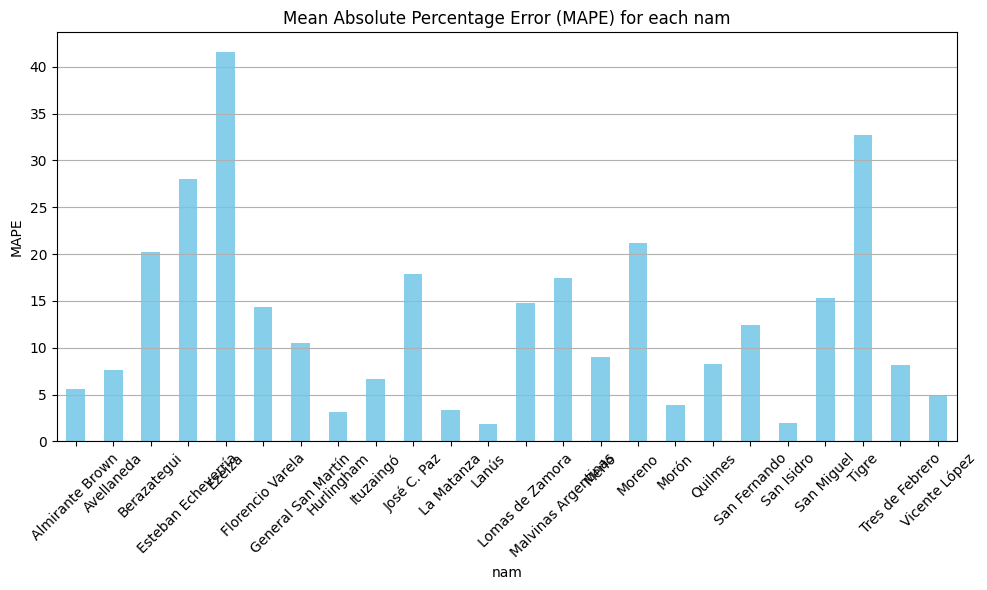

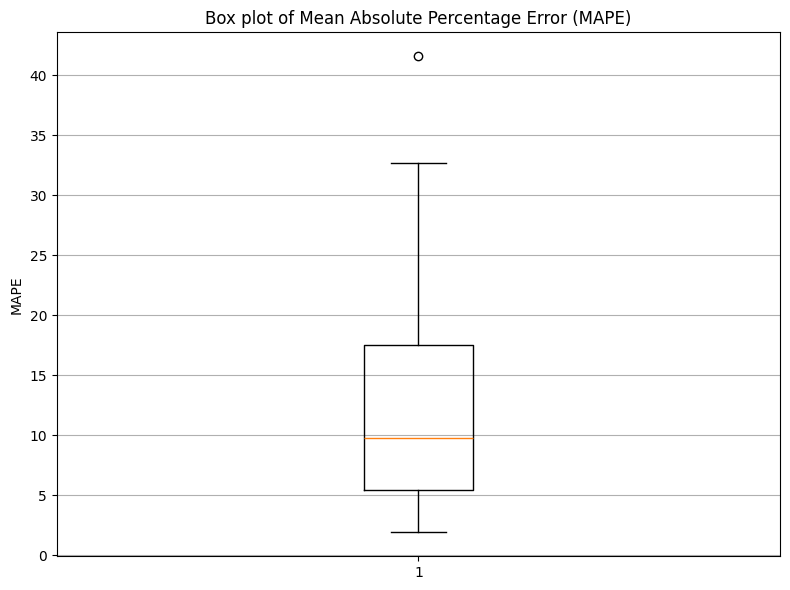

In [13]:


# Plot MAPE for each 'nam' in a bar chart
plt.figure(figsize=(10, 6))
result_df.groupby('nam')['MAPE'].mean().plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Percentage Error (MAPE) for each nam')
plt.xlabel('nam')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Create a box plot of the MAPE series
plt.figure(figsize=(8, 6))
plt.boxplot(result_df['MAPE'])
plt.title('Box plot of Mean Absolute Percentage Error (MAPE)')
plt.ylabel('MAPE')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [14]:
def evaluate_model_for_nam(nam):
    # Subset data for the given 'nam'
    nam_data = df[df['nam'] == nam]
    
    # Define features and target variable
    X = nam_data.drop(['pob','nam'], axis=1)  # Features
    y = nam_data['pob']  # Target variable
    
    # Initialize models
    random_forest = RandomForestRegressor(random_state=42)
    gradient_boosting = GradientBoostingRegressor(random_state=42)
    
    # Perform cross-validation
    rf_scores = cross_val_score(random_forest, X, y, cv=2, scoring='neg_mean_squared_error')
    gb_scores = cross_val_score(gradient_boosting, X, y, cv=2, scoring='neg_mean_squared_error')
    
    # Convert scores to positive values and calculate RMSE
    rf_rmse_scores = np.sqrt(-rf_scores)
    gb_rmse_scores = np.sqrt(-gb_scores)
    
    # Print the mean RMSE scores
    print(f"Random Forest RMSE for {nam}:", np.mean(rf_rmse_scores))
    print(f"Gradient Boosting RMSE for {nam}:", np.mean(gb_rmse_scores))
    
    return np.mean(rf_rmse_scores), np.mean(gb_rmse_scores)

# Apply the function to each 'nam'
for nam in df['nam'].unique():
    print(f"Evaluating models for {nam}:")
    evaluate_model_for_nam(nam)
    print()


Evaluating models for Almirante Brown:
Random Forest RMSE for Almirante Brown: 50783.86985593553
Gradient Boosting RMSE for Almirante Brown: 41589.75356406157

Evaluating models for Avellaneda:
Random Forest RMSE for Avellaneda: 20624.401401797135
Gradient Boosting RMSE for Avellaneda: 16049.95785644163

Evaluating models for Berazategui:
Random Forest RMSE for Berazategui: 67862.33377407772
Gradient Boosting RMSE for Berazategui: 59568.87197877531

Evaluating models for Esteban Echeverría:
Random Forest RMSE for Esteban Echeverría: 58681.3635977478
Gradient Boosting RMSE for Esteban Echeverría: 48835.48550980678

Evaluating models for Ezeiza:
Random Forest RMSE for Ezeiza: 61069.44164666275
Gradient Boosting RMSE for Ezeiza: 54824.02058707036

Evaluating models for Florencio Varela:
Random Forest RMSE for Florencio Varela: 66772.74756599839
Gradient Boosting RMSE for Florencio Varela: 79366.14865419785

Evaluating models for General San Martín:
Random Forest RMSE for General San Martí

### RANDOM FOREST

In [15]:

#subset_data = df[(df['nam'] == 'La Matanza') & df['anio'].isin([1991, 2001, 2010])].head().info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 95
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nam        90 non-null     object 
 1   cod_depto  90 non-null     object 
 2   anio       90 non-null     int32  
 3   pob        90 non-null     float64
 4   var        90 non-null     float64
 5   muj        90 non-null     float64
 6   sup        90 non-null     object 
 7   ind_masc   90 non-null     object 
 8   dens_pob   90 non-null     object 
dtypes: float64(3), int32(1), object(5)
memory usage: 6.7+ KB


In [16]:
def predict_population_for_2022(nam):
    # Subset data for the given 'nam' and the specified years
    subset_data = df[(df['nam'] == nam) & df['anio'].isin([1991, 2001, 2010])]
    
    # Check if there are enough samples available for training
    if len(subset_data) < 3:
        print(f"Not enough data available for {nam}. Skipping...")
        return None
    
    # Define features and target variable for training
    X_train = subset_data.drop(['pob'], axis=1)  # Features
    y_train = subset_data['pob']  # Target variable
    
    # Convert categorical variables to one-hot encoding
    X_train_encoded = pd.get_dummies(X_train)
    
    # Initialize model (Random Forest as an example)
    model = RandomForestRegressor(random_state=42)
    
    # Train the model
    model.fit(X_train_encoded, y_train)
    
    # Subset data for the year 2022
    data_2022 = df[(df['nam'] == nam) & (df['anio'] == 2022)]
    
    # Check if there are samples available for prediction
    if len(data_2022) == 0:
        print(f"No data available for prediction in 2022 for {nam}. Skipping...")
        return None
    
    # Define features for prediction
    X_2022 = data_2022.drop(['pob'], axis=1)  # Features for 2022
    X_2022_encoded = pd.get_dummies(X_2022)  # Convert categorical variables
    
    # Ensure consistent feature names
    # Add missing columns with 0s
    missing_cols = set(X_train_encoded.columns) - set(X_2022_encoded.columns)
    for col in missing_cols:
        X_2022_encoded[col] = 0
    
    # Reorder columns to match training data
    X_2022_encoded = X_2022_encoded[X_train_encoded.columns]
    
    # Predict the population for 2022
    population_2022 = model.predict(X_2022_encoded)[0]  # Taking the first prediction
    
    # Create a dataset with the results for the given 'nam'
    result_data = pd.DataFrame({
        'nam': [nam],
        'Predicted_Population_2022': [population_2022]
    })
    
    return result_data

# Apply the function to each 'nam'
results = pd.concat([predict_population_for_2022(nam) for nam in df['nam'].unique() if predict_population_for_2022(nam) is not None], ignore_index=True)

# Display the results dataset
print(results)


Not enough data available for Ezeiza. Skipping...
Not enough data available for Hurlingham. Skipping...
Not enough data available for Ituzaingó. Skipping...
Not enough data available for José C. Paz. Skipping...
Not enough data available for Malvinas Argentinas. Skipping...
Not enough data available for San Miguel. Skipping...
                   nam  Predicted_Population_2022
0      Almirante Brown                  519861.90
1           Avellaneda                  338442.15
2          Berazategui                  296622.02
3   Esteban Echeverría                  283987.87
4     Florencio Varela                  366212.47
5   General San Martín                  410316.55
6           La Matanza                 1483548.72
7                Lanús                  460940.35
8      Lomas de Zamora                  600975.10
9                Merlo                  481486.10
10              Moreno                  396202.06
11               Morón                  375278.35
12             Quilme

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Create an empty list to store the results
evaluation_results = []

# Iterate over each 'nam'
for nam in df['nam'].unique():
    # Get the predicted population for 2022
    predicted_data = predict_population_for_2022(nam)
    
    # Skip if prediction is not available
    if predicted_data is None:
        continue
    
    # Get the real population for 2022
    real_data = df[(df['nam'] == nam) & (df['anio'] == 2022)]
    
    # Skip if real data is not available
    if len(real_data) == 0:
        print(f"No real data available for {nam} in 2022. Skipping...")
        continue
    
    # Calculate MSE
    mse = mean_squared_error(real_data['pob'], predicted_data['Predicted_Population_2022'])
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    # Calculate MAPE
    real_population = real_data['pob'].values[0]
    predicted_population = predicted_data['Predicted_Population_2022'].values[0]
    
    if real_population == 0:
        mape = np.nan  # Set MAPE to NaN if real population is zero
    else:
        mape = np.mean(np.abs((real_population - predicted_population) / real_population)) * 100
    
    # Round the predicted population to the nearest integer
    predicted_population = int(round(predicted_population))
    
    # Append the results to the list
    evaluation_results.append({
        'nam': nam,
        'Real_Population_2022': real_population,
        'Predicted_Population_2022': predicted_population,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape.round(3)
    })

# Convert the list to a DataFrame
evaluation_results_df = pd.DataFrame(evaluation_results)

# Display the evaluation results
print(evaluation_results_df)


Not enough data available for Ezeiza. Skipping...
Not enough data available for Hurlingham. Skipping...
Not enough data available for Ituzaingó. Skipping...
Not enough data available for José C. Paz. Skipping...
Not enough data available for Malvinas Argentinas. Skipping...
Not enough data available for San Miguel. Skipping...
                   nam  Real_Population_2022  Predicted_Population_2022  \
0      Almirante Brown              585852.0                     519862   
1           Avellaneda              370939.0                     338442   
2          Berazategui              360582.0                     296622   
3   Esteban Echeverría              339030.0                     283988   
4     Florencio Varela              497818.0                     366212   
5   General San Martín              450335.0                     410317   
6           La Matanza             1837774.0                    1483549   
7                Lanús              462051.0                     460940

Average MAPE: 13.368722222222223


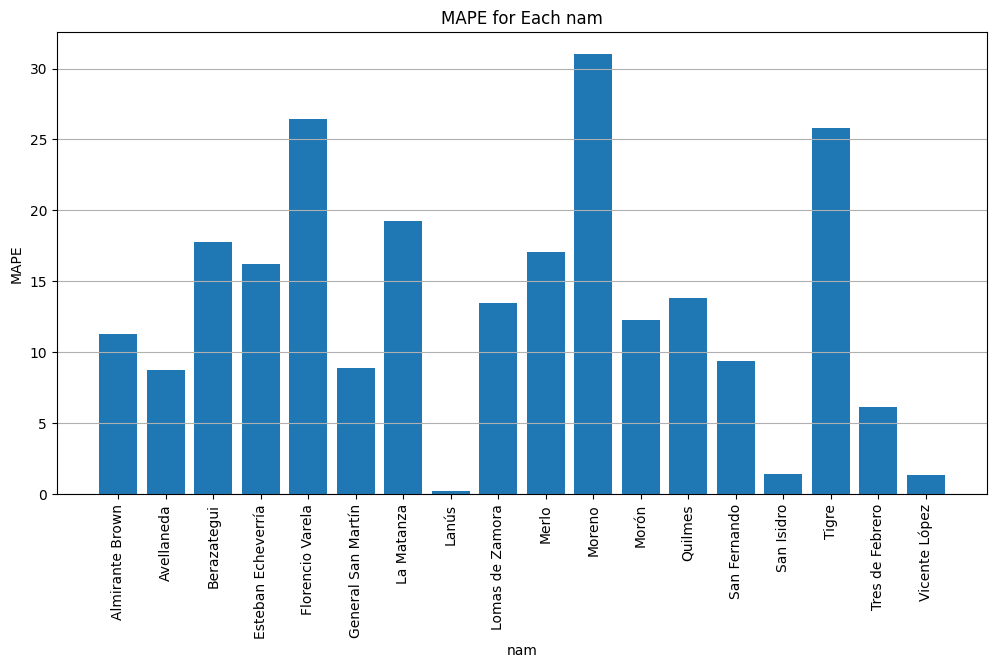

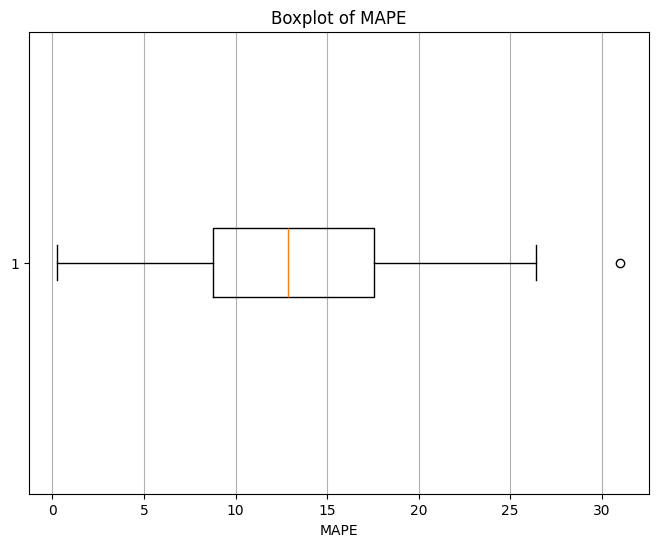

In [18]:
# Calculate the average MAPE
average_mape = evaluation_results_df['MAPE'].mean()
print("Average MAPE:", average_mape)

# Plot bar chart of MAPE for each 'nam'
plt.figure(figsize=(12, 6))
plt.bar(evaluation_results_df['nam'], evaluation_results_df['MAPE'])
plt.title('MAPE for Each nam')
plt.xlabel('nam')
plt.ylabel('MAPE')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# Create a boxplot for the MAPE series
plt.figure(figsize=(8, 6))
plt.boxplot(evaluation_results_df['MAPE'], vert=False)
plt.title('Boxplot of MAPE')
plt.xlabel('MAPE')
plt.grid(axis='x')
plt.show()


### LGM BOOST

In [19]:
import lightgbm as lgb

# Define the function to train a LightGBM model and make predictions for 2022
def predict_population_for_2022_lgb(nam):
    # Subset data for the given 'nam' and the specified years
    subset_data = df[(df['nam'] == nam) & df['anio'].isin([1991, 2001, 2010])]
    
    # Check if there are enough samples available for training
    if len(subset_data) < 3:
        print(f"Not enough data available for {nam}. Skipping...")
        return None
    
    # Define features and target variable for training
    X_train = subset_data.drop(['pob'], axis=1)  # Features
    y_train = subset_data['pob']  # Target variable
    
    # Convert categorical variables to one-hot encoding
    X_train_encoded = pd.get_dummies(X_train)
    
    # Initialize LightGBM model
    lgb_model = lgb.LGBMRegressor(random_state=42)
    
    # Train the model
    lgb_model.fit(X_train_encoded, y_train)
    
    # Subset data for the year 2022
    data_2022 = df[(df['nam'] == nam) & (df['anio'] == 2022)]
    
    # Check if there are samples available for prediction
    if len(data_2022) == 0:
        print(f"No data available for prediction in 2022 for {nam}. Skipping...")
        return None
    
    # Define features for prediction
    X_2022 = data_2022.drop(['pob'], axis=1)  # Features for 2022
    X_2022_encoded = pd.get_dummies(X_2022)  # Convert categorical variables
    
    # Ensure consistent feature names
    # Add missing columns with 0s
    missing_cols = set(X_train_encoded.columns) - set(X_2022_encoded.columns)
    for col in missing_cols:
        X_2022_encoded[col] = 0
    
    # Reorder columns to match training data
    X_2022_encoded = X_2022_encoded[X_train_encoded.columns]
    
    # Predict the population for 2022
    population_2022 = lgb_model.predict(X_2022_encoded)[0]  # Taking the first prediction
    
    # Create a dataset with the results for the given 'nam'
    result_data = pd.DataFrame({
        'nam': [nam],
        'Predicted_Population_2022': [population_2022]
    })
    
    return result_data

# Create an empty list to store the results
evaluation_results_lgb = []

# Iterate over each 'nam'
for nam in df['nam'].unique():
    # Get the predicted population for 2022 using LightGBM
    predicted_data_lgb = predict_population_for_2022_lgb(nam)
    
    # Skip if prediction is not available
    if predicted_data_lgb is None:
        continue
    
    # Get the real population for 2022
    real_data_lgb = df[(df['nam'] == nam) & (df['anio'] == 2022)]
    
    # Skip if real data is not available
    if len(real_data_lgb) == 0:
        print(f"No real data available for {nam} in 2022. Skipping...")
        continue
    
    # Calculate MSE
    mse_lgb = mean_squared_error(real_data_lgb['pob'], predicted_data_lgb['Predicted_Population_2022'])
    
    # Calculate RMSE
    rmse_lgb = np.sqrt(mse_lgb)
    
    # Calculate MAPE
    real_population_lgb = real_data_lgb['pob'].values[0]
    predicted_population_lgb = predicted_data_lgb['Predicted_Population_2022'].values[0]
    
    if real_population_lgb == 0:
        mape_lgb = np.nan  # Set MAPE to NaN if real population is zero
    else:
        mape_lgb = np.mean(np.abs((real_population_lgb - predicted_population_lgb) / real_population_lgb)) * 100
    
    # Round the predicted population to the nearest integer
    predicted_population_lgb = int(round(predicted_population_lgb))
    
    # Append the results to the list
    evaluation_results_lgb.append({
        'nam': nam,
        'Real_Population_2022': real_population_lgb,
        'Predicted_Population_2022': predicted_population_lgb,
        'MSE': mse_lgb,
        'RMSE': rmse_lgb,
        'MAPE': mape_lgb
    })

# Convert the list to a DataFrame
evaluation_results_lgb_df = pd.DataFrame(evaluation_results_lgb)

# Display the evaluation results for LightGBM
print(evaluation_results_lgb_df)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 3, number of used features: 0
[LightGBM] [Info] Start training from score 506385.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

Mean MAPE for LightGBM: 16.211565588009638


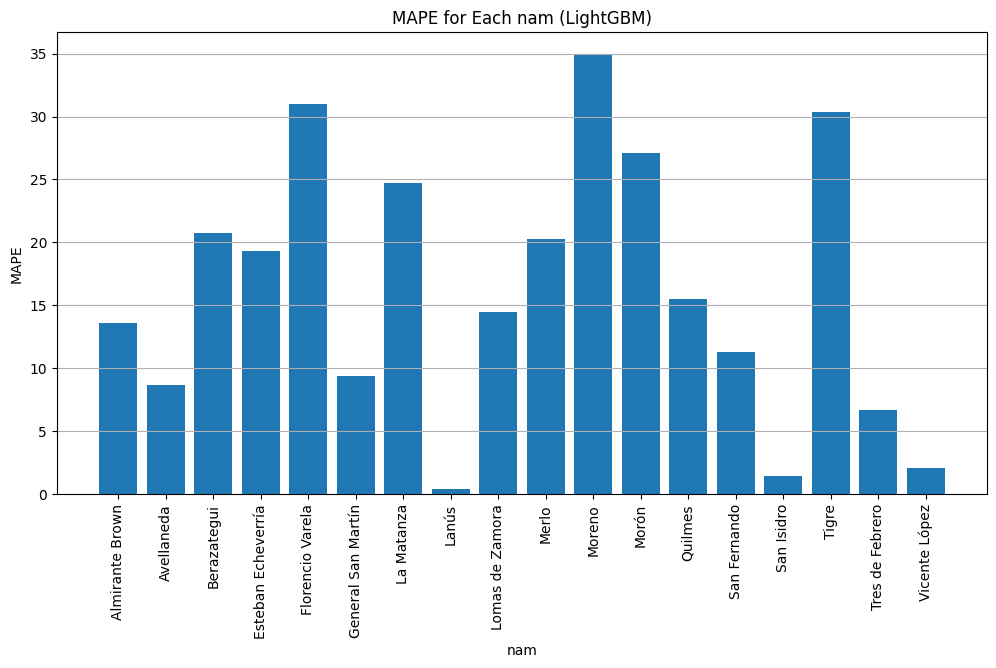

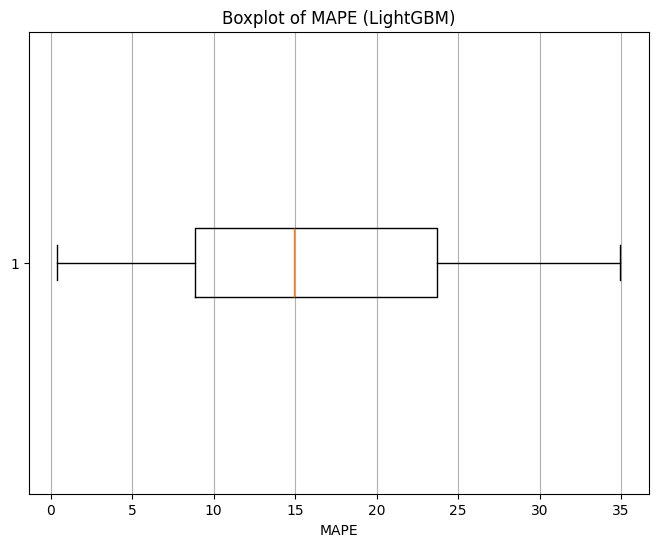

In [20]:
# Calculate the mean MAPE
mean_mape_lgb = evaluation_results_lgb_df['MAPE'].mean()
print("Mean MAPE for LightGBM:", mean_mape_lgb)

# Plot bar chart of MAPE for each 'nam' for LightGBM
plt.figure(figsize=(12, 6))
plt.bar(evaluation_results_lgb_df['nam'], evaluation_results_lgb_df['MAPE'])
plt.title('MAPE for Each nam (LightGBM)')
plt.xlabel('nam')
plt.ylabel('MAPE')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# Create a boxplot for the MAPE series for LightGBM
plt.figure(figsize=(8, 6))
plt.boxplot(evaluation_results_lgb_df['MAPE'], vert=False)
plt.title('Boxplot of MAPE (LightGBM)')
plt.xlabel('MAPE')
plt.grid(axis='x')
plt.show()


In [23]:

evaluation_results_lgb_df['anio']=2022
df1=evaluation_results_lgb_df
# Define the file path
file_path = 'ext_LR_RT_RF_All.csv'

# Read the CSV file into a DataFrame
ext = pd.read_csv(file_path)

# Perform the merge based on the columns 'anio' and 'nam'
merged_df = ext.merge(df1, on=['anio', 'nam'], how='left')

df_final=merged_df.drop(columns=['Real_Population_2022'])
# Rename columns in the DataFrame
df_final = df_final.rename(columns={'Predicted_Population_2022': 'Pred_LGB', 'MAPE': 'MAPE_LGB','MSE':'MSE_LGB','RMSE':'RMSE_LGB'})


df_final.head()


,nam,cod_depto,anio,pob,var,muj,vivpart,vivtotal,sup,ind_masc,...,MSE_RT,RMSE_RT,Pred_RF,MSE_RF,RMSE_RF,MAPE_RF,Pred_LGB,MSE_LGB,RMSE_LGB,MAPE_LGB
0,Almirante Brown,6028,1991,450698.0,222042.0,228656.0,NaN,NaN,157.87,97.1,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Almirante Brown,6028,2010,552902.0,270247.0,282655.0,156218.0,78.0,157.87,95.6,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Almirante Brown,6028,2022,585852.0,281842.0,301779.0,184403.0,60.0,157.87,93.4,...,1085702500,32950.0,521336.0,4.162335e+09,64516.16,11.012,506385.0,6.314951e+09,79466.666667,13.56429
3,Almirante Brown,6028,2001,515556.0,252454.0,263102.0,143543.0,88.0,157.87,96.0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Avellaneda,6035,2001,328980.0,155450.0,173530.0,117200.0,59.0,68.54,89.6,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Define the file path
file_path ='extended_All.csv'

# Export the DataFrame to a CSV file
df_final.to_csv(file_path, index=False)

print("CSV file has been saved successfully!")


CSV file has been saved successfully!
